TODO: GET TRAINING UP AND RUNNING
TODO: TRANSFER MODEL TO COVERS1000

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os

from glob import glob

import librosa
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
from torch.optim import Adam

from sklearn.model_selection import KFold
import time

In [2]:
# performing a check
id = 35
path = f'/content/drive/MyDrive/Year 4 - Semester 1/Independent Study/Datasets/DEAM_audio/MEMD_audio/{id}.mp3'
y, sr = librosa.load(path, sr=44100)
print(f"{len(y)} samples at {sr} Hz")


1986607 samples at 44100 Hz


In [3]:
def compute_beats(y, sr, hop_length):

    tempo, beat_frames = librosa.beat.beat_track(
        y=y,
        sr=sr,
        hop_length=hop_length,
        units="frames"
    )

    beat_times_sec = librosa.frames_to_time(
        beat_frames,
        sr=sr,
        hop_length=hop_length
    )

    return beat_times_sec, beat_frames, tempo

In [4]:
def aggregate_feature(mfcc, hpcp, cens, beat_frames, beat_times):

    X = []
    durations = []

    # beat_durations = np.diff(beat_times)
    # beat_durations = np.clip(beat_durations, 1e-2, None)

    # tempo_inst = 60.0 / beat_durations
    # tempo_features = np.column_stack([
    #         tempo_inst,
    #         np.log(tempo_inst),
    #         np.diff(np.concatenate([[tempo_inst[0]], tempo_inst]))
    #     ])

    for t in range(len(beat_frames) - 1):
        start = beat_frames[t]
        end   = beat_frames[t + 1]

        if end > start:
            mfcc_t = mfcc[start:end].mean(axis=0)
            hpcp_t = hpcp[start:end].mean(axis=0)
            cens_t = cens[start:end].mean(axis=0)
        else:
            mfcc_t = mfcc[start]
            hpcp_t = hpcp[start:end]
            cens_t = cens[start:end]

        X.append(np.concatenate([mfcc_t, hpcp_t, cens_t]))
        durations.append(beat_times[t + 1] - beat_times[t])



    X = np.vstack(X)
    return X, np.array(durations)

In [5]:
def parse_annotation_times(df):

    time_cols = [c for c in df.columns if c.startswith("sample_")]

    times_sec = np.array([int(c.replace("sample_", "").replace("ms", "")) / 1000.0
                          for c in time_cols])

    return time_cols, times_sec

In [6]:
def aggregate_annotations_to_beats(
        times_sec,
        values,
        beat_times_sec
):

    y_beats = []

    for t in range(len(beat_times_sec) - 1):
        start = beat_times_sec[t]
        end   = beat_times_sec[t + 1]

        mask = (times_sec >= start) & (times_sec < end)

        if np.any(mask):
            y_beats.append(values[mask].mean())
        else:
            # fallback: nearest neighbor
            idx = np.argmin(np.abs(times_sec - start))
            y_beats.append(values[idx])
    return np.array(y_beats)

In [7]:
def get_song_ids(filepath):

    ids = []
    for root, dirs, files in os.walk(filepath):
        for file in files:
            if ".mp3" in file:
                ids.append(file[:file.index(".")])

    return ids

In [8]:
class DEAMDataset(Dataset):

    def __init__(
            self,
            audio_dir,
            arousal_labels,
            valence_labels,
            song_ids,
            hop_length=512,
            n_mfcc=20
    ):

        self.audio_dir = audio_dir
        self.arousal_labels = pd.read_csv(arousal_labels)
        self.valence_labels = pd.read_csv(valence_labels)
        self.hop_length = hop_length
        self.n_mfcc = n_mfcc
        self.song_ids = song_ids
        self.cache = {}

    def __len__(self):
        return len(self.song_ids)

    def __getitem__(self, idx):

        time_cols, time_sec = parse_annotation_times(self.valence_labels)

        song_id = self.song_ids[idx]

        if song_id in self.cache:
          return self.cache[song_id]

        path = os.path.join(self.audio_dir, f"{song_id}.mp3")

        y, sr = librosa.load(path, sr=44100)

        beat_times_sec, beat_frames, tempo = compute_beats(y, sr, self.hop_length)

        if beat_times_sec is None or len(beat_times_sec) < 2:
          return None

        mfcc = librosa.feature.mfcc(
            y=y,
            sr=sr,
            n_mfcc=self.n_mfcc,
            hop_length=self.hop_length
        ).T

        y_harmonic, _ = librosa.effects.hpss(y)

        hpcp = librosa.feature.chroma_cqt(
            y=y_harmonic,
            sr=sr,
            bins_per_octave=self.hop_length,
            n_chroma=self.hop_length
        ).T

        cens = librosa.feature.chroma_cens(
            y=y,
            sr=sr,
            hop_length=self.hop_length
        ).T

        X, durations = aggregate_feature(mfcc, hpcp, cens, beat_frames, beat_times_sec)

        val_row = self.valence_labels.loc[
            self.valence_labels["song_id"].astype(str).str.strip() == str(song_id).strip()
        ]
        valence = val_row.reindex(columns=time_cols).iloc[0].values

        aro_row = self.arousal_labels.loc[
            self.arousal_labels["song_id"].astype(str).str.strip() == str(song_id).strip()
        ]
        arousal = aro_row.reindex(columns=time_cols).iloc[0].values

        val_beats = aggregate_annotations_to_beats(time_sec, valence, beat_times_sec)
        aro_beats = aggregate_annotations_to_beats(time_sec, arousal, beat_times_sec)

        X = torch.tensor(X, dtype=torch.float32)

        y = np.column_stack([val_beats, aro_beats])
        y = torch.tensor(y, dtype=torch.float32)

        durations = torch.tensor(durations, dtype=torch.float32)

        if X.shape[0] == 0 or y.shape[0] == 0:
          return None

        sample = {
            "X": X,
            "y": y,
            "durations": durations
        }

        self.cache[song_id] = sample
        return sample


In [9]:
ids = get_song_ids("/content/drive/MyDrive/Year 4 - Semester 1/Independent Study/Datasets/DEAM_audio/MEMD_audio")

dataset = DEAMDataset("/content/drive/MyDrive/Year 4 - Semester 1/Independent Study/Datasets/DEAM_audio/MEMD_audio",
                           "/content/drive/MyDrive/Year 4 - Semester 1/Independent Study/Datasets/arousal.csv",
                           "/content/drive/MyDrive/Year 4 - Semester 1/Independent Study/Datasets/valence.csv",
                           ids)

sample = dataset[0]


print(sample["X"].shape)

1806 86
torch.Size([85, 544])


In [10]:
print(sample["y"].shape)
print(sample["durations"].shape)
print("Mean beat duration:", sample["durations"].mean().item())

torch.Size([85, 2])
torch.Size([85])
Mean beat duration: 0.5000485777854919


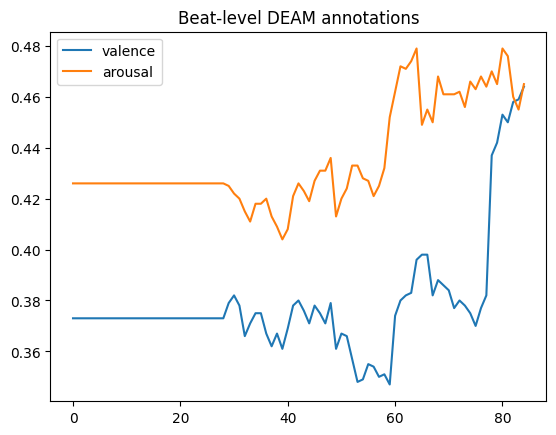

In [11]:

plt.plot(sample["y"][:, 0], label="valence")
plt.plot(sample["y"][:, 1], label="arousal")
plt.legend()
plt.title("Beat-level DEAM annotations")
plt.show()

In [12]:
class BeatRegressor(nn.Module):

    def __init__(self, input_dim):

        super().__init__()
        self.next = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.net(x)

In [13]:
def flatten_collate(batch):

    batch = [b for b in batch if b is not None]

    if len(batch) == 0:
        return None, None

    X_list = [b["X"] for b in batch]
    y_list = [b["y"] for b in batch]

    X = torch.cat(X_list, dim=0)
    y = torch.cat(y_list, dim=0)

    return X, y



In [14]:
num_songs = len(dataset)
indices = np.arange(num_songs)
kf = KFold(n_splits=10, shuffle=True, random_state=42)


In [15]:
def compute_normalization(loader):
    X_all = []

    for X, _ in loader:
        if X is None:
            continue
        if X.numel() == 0:
            continue
        X_all.append(X)

    if len(X_all) == 0:
        raise RuntimeError("No valid samples found")

    X_all = torch.cat(X_all, dim=0)
    mean = X_all.mean(dim=0)
    std = X_all.std(dim=0) + 1e-6
    return mean, std

In [16]:

device = "cuda" if torch.cuda.is_available() else "cpu"

valid = 0
invalid = 0

for i in range(len(dataset)):
    sample = dataset[i]
    if sample is None:
        invalid += 1
    else:
        valid += 1

print("Valid songs:", valid)
print("Invalid songs:", invalid)

# fold_results = []

# start = time.time()
# for fold, (train_idx, val_idx) in enumerate(kf.split(indices)):
#     print("Epoch time:", time.time() - start)
#     print(f"===== Fold {fold} of 10 =====")

#     train_set = Subset(dataset, train_idx)

#     for i in range(len(train_set)):
#         try:
#             sample = train_set[i]
#         except Exception as e:
#             print(f"Error at train_set index {i}")
#             raise


#     val_set = Subset(dataset, val_idx)

#     train_loader = DataLoader(
#         train_set,
#         batch_size=8,
#         shuffle=True,
#         collate_fn=flatten_collate
#     )

#     # for i, (X, y) in enumerate(train_loader):
#     #     print(i, X.shape)

#     val_loader = DataLoader(
#         dataset=val_set,
#         batch_size=8,
#         shuffle=False,
#         collate_fn=flatten_collate
#     )

#     batch = next(iter(train_loader))
#     print(type(batch))
#     print(batch)

#     print("test")

#     mean, std = compute_normalization(train_loader)

#     print("test")

#     input_dim = train_set[0]["X"].shape[1]
#     model = BeatRegressor(input_dim).to(device)

#     optimizer = Adam(model.parameters(), lr=1e-3)
#     criterion = nn.MSELoss()

#     best_val_loss = float("inf")

#     print("test")

#     for epoch in range(30):
#         model.train()
#         train_loss = 0.0

#         print("test")

#         for X, y in train_loader:
#             X = ((X - mean) / std).to(device)
#             y = y.to(device)

#             optimizer.zero_grad()
#             y_hat = model(X)
#             loss = criterion(y_hat, y)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item()

#         model.eval()

#         print("test")

#         val_loss = 0.0
#         with torch.no_grad():
#             for X, y in val_loader:
#                 X = ((X - mean) / std).to(device)
#                 y = y.to(device)
#                 y_hat = model(X)
#                 val_loss += criterion(y_hat, y).item()

#         print(
#             f"Epoch {epoch+1:02d} | "
#             f"Train MSE: {train_loss:.4f} | "
#             f"Val MSE: {val_loss:.4f}"
#         )

#         best_val_loss = min(best_val_loss, val_loss)

#     fold_results.append(best_val_loss)



1695 105
1677 119
1701 118
1728 81
1832 80
1738 123
1687 123
1826 48
1724 46
1770 82
1791 88
1835 93
1859 56
1837 84
1756 58
1739 74
1843 62
1922 106
1689 95
1854 86
1852 77
1912 75
1815 89
1742 76
171 9
1909 99
1876 111
1862 77
1878 86
1712 76
1818 75
1672 65
1899 147
174 67
1735 85
180 74
191 66
1764 87
1907 119
1778 60
1847 44
1880 65
1867 1
1797 97
1803 123
184 86
1754 86
1785 78
1789 86
1816 50
1886 98
1822 74
1704 80
1802 88
1678 86
170 119
1702 94
1781 40
1787 80
1808 49
1893 108
1774 90
1866 48
1894 103
1751 72
1908 107
1752 85
1686 85
1761 77
1740 125
1720 86
1913 117
1693 83
1918 82
1782 64
1765 87
1773 109
1685 71
1919 75
1916 56
1713 83
1838 113
1755 82
1741 107
1850 98
1911 38
1798 115
1793 76
1783 78
1817 84
1760 80
1871 79
1921 69
1840 83
1746 84
1891 82
1906 79
1849 118
1749 92
18 69
168 89
1868 113
1874 95
1779 85
1772 63
1834 60
1810 89
1853 85
181 103
1745 74
1790 70
1753 62
1901 95
1856 83
1881 43
1892 90
1841 113
1711 85
1750 94
175 67
1691 65
1675 69
1820 73
1900 

KeyboardInterrupt: 

In [ ]:
fold_results = np.array(fold_results)

print("10-Fold CV Results:")
print(f"Mean MSE: {fold_results.mean():.4f}")
print(f"Std  MSE: {fold_results.std():.4f}")
